# Model fitting 1: Only SSC

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [2]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [3]:
print(test_SEDs[1])
data=Data.from_file(test_SEDs[1])


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv



***  binning data  ***
---> N bins= 89
---> bin_widht= 0.2



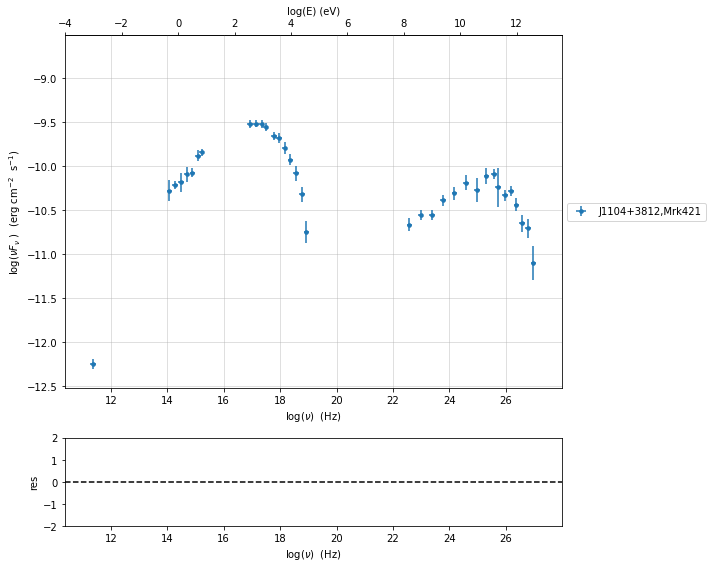

In [4]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [5]:
sed_data.save('Mrk_401.pkl')

## phenomenological model constraining

### spectral indices


*** evaluating spectral indices for data ***



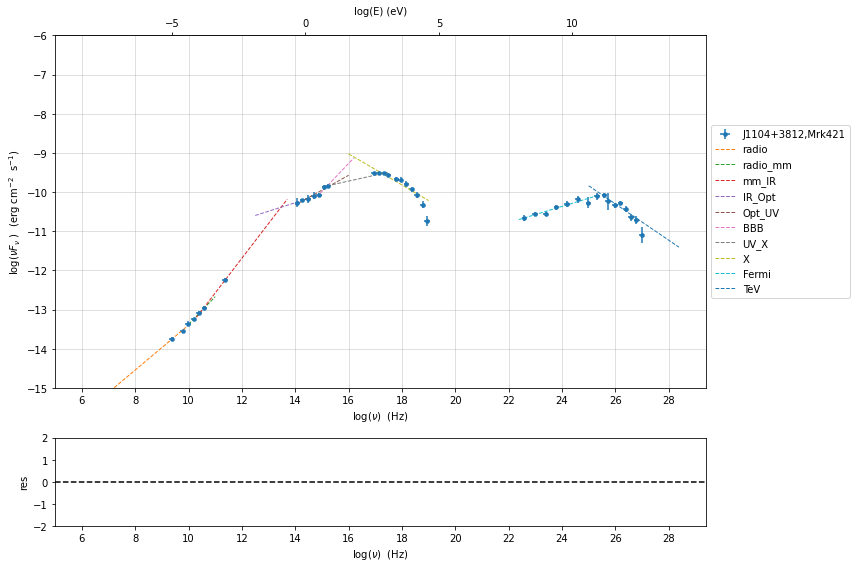

In [6]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

### sed shaper

In [7]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=False,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP





model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.545300e-01,-1.545300e-01,9.534795e-03,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.023245e-02,-1.023245e-02,1.433073e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.672267e+01,1.672267e+01,4.139942e-02,--,1.667039e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-9.491659e+00,-9.491659e+00,2.515285e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> sync       nu_p=+1.672267e+01 (err=+4.139942e-02)  nuFnu_p=-9.491659e+00 (err=+2.515285e-02) curv.=-1.545300e-01 (err=+9.534795e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-2.098186e-01,-2.098186e-01,3.133100e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.661867e-02,-4.661867e-02,2.178435e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.524926e+01,2.524926e+01,1.147802e-01,--,2.529412e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.011085e+01,-1.011085e+01,3.498963e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.524926e+01 (err=+1.147802e-01)  nuFnu_p=-1.011085e+01 (err=+3.498963e-02) curv.=-2.098186e-01 (err=+3.133100e-02)



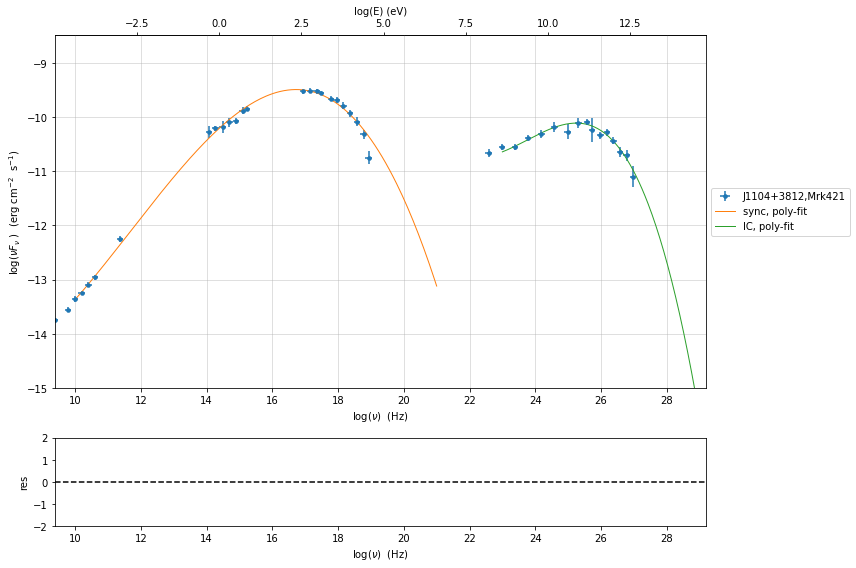

In [8]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [9]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060843e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False


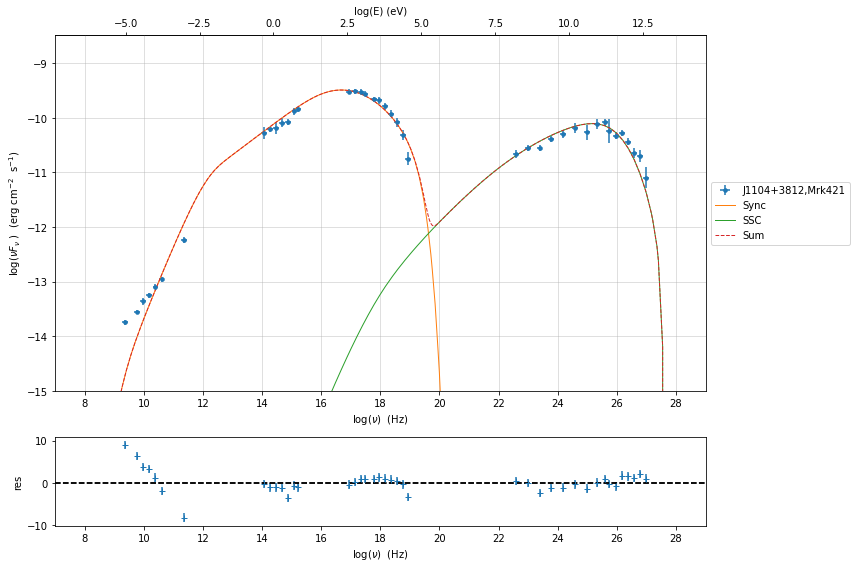

In [10]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

## Model fitting procedure

### Model fitting with LSB

In [11]:
from jetset.minimizer import fit_SED,ModelMinimizer

from jetset.model_manager import  FitModel
from jetset.jet_model import Jet


if you want to fit the `prefit_model` you can load the saved one (this allows you to save time) ad pass it to the `FitModel` class

In [12]:
prefit_jet=Jet.load_model('prefit_jet.pkl')
fit_model_lsb=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None) 


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060843e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


OR use the one generated above

In [13]:
fit_model_lsb=FitModel( jet=prefit_jet, name='SSC-best-fit-lsb',template=None) 

In [14]:
fit_model_lsb.show_model_components()


--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------


There is only one component, whit name `jet_leptonic`, that refers to the `prefit_jet` model component

We now set the gamma grid size to 200, ad we set `composite_expr`, anyhow, since we have only one component this step could be skipped

In [25]:
fit_model_lsb.jet_leptonic.set_gamma_grid_size(200)
fit_model_lsb.composite_expr='jet_leptonic'

### Freezeing parameters and setting fit_range intervals

These methods are alternative and equivalent ways to access a model component for setting parameters state and values 


a) passing as first argument, of the method, the model component `name`

b) passing as first argument, of the method, the model component `object`

c) accessing the model component member of the composite model class 

In [26]:
#a
fit_model_lsb.freeze('jet_leptonic','z_cosm')
fit_model_lsb.freeze('jet_leptonic','R_H')
#b
fit_model_lsb.freeze(prefit_jet,'R')
#c
fit_model_lsb.jet_leptonic.parameters.R.fit_range=[10**15.5,10**17.5]
fit_model_lsb.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]

### Building the ModelMinimizer object

Now we build a `lsb` model minimizer and run the fit method

In [27]:
model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model_lsb,
                                     sed_data,
                                     1E11,
                                     1E29,
                                     fitname='SSC-best-fit-minuit',
                                     repeat=3)


filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]


- best chisq=5.24047e+01
fit run: 1
- old chisq=5.24047e+01


0it [00:00, ?it/s]


- best chisq=5.16902e+01
fit run: 2
- old chisq=5.16902e+01


0it [00:00, ?it/s]


- best chisq=5.04336e+01
-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.877517e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,9.155123e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.123778e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.519487e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.194458e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.725934e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,True
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.000450e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.335973e+01,1.000000e-04,--,False,False



converged=True
calls=64
mesg=


'The relative error between two consecutive iterates is at most 0.000000'

dof=27
chisq=50.433624, chisq/red=1.867912 null hypothesis sig=0.004054

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,4.877517e+02,4.877517e+02,6.501616e+02,--,4.839453e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,9.155123e+05,9.155123e+05,1.115877e+05,--,9.168777e+05,1.000000e+00,1.000000e+15,False
jet_leptonic,N,9.123778e-01,9.123778e-01,1.306186e+00,--,9.106489e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.519487e+04,4.519487e+04,1.363282e+04,--,4.515437e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.194458e+00,2.194458e+00,1.091468e-01,--,2.195953e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,7.725934e-01,7.725934e-01,8.790054e-02,--,7.718981e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.112712e+16,--,--,--,3.112712e+16,3.162278e+15,3.162278e+17,True
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,5.000450e-02,5.000450e-02,1.217919e-02,--,4.993353e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,2.335973e+01,2.335973e+01,3.222586e+00,--,2.352651e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




we can obtain the best fit astropy table

In [28]:
best_fit_lsb.bestfit_table

model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
str12,str16,float64,float64,float64,float64,float64,float64,float64,bool
jet_leptonic,gmin,4.877517e+02,4.877517e+02,6.501616e+02,--,4.839453e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,9.155123e+05,9.155123e+05,1.115877e+05,--,9.168777e+05,1.000000e+00,1.000000e+15,False
jet_leptonic,N,9.123778e-01,9.123778e-01,1.306186e+00,--,9.106489e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.519487e+04,4.519487e+04,1.363282e+04,--,4.515437e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.194458e+00,2.194458e+00,1.091468e-01,--,2.195953e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,7.725934e-01,7.725934e-01,8.790054e-02,--,7.718981e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.112712e+16,--,--,--,3.112712e+16,3.162278e+15,3.162278e+17,True
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,5.000450e-02,5.000450e-02,1.217919e-02,--,4.993353e-02,0.000000e+00,--,False


## saving fit model, model minimizer

We can save all the fit products to be used later.

In [29]:
best_fit_lsb.save_report('SSC-best-fit-lsb.txt')
model_minimizer_lsb.save_model('model_minimizer_lsb.pkl')
fit_model_lsb.save_model('fit_model_lsb.pkl')

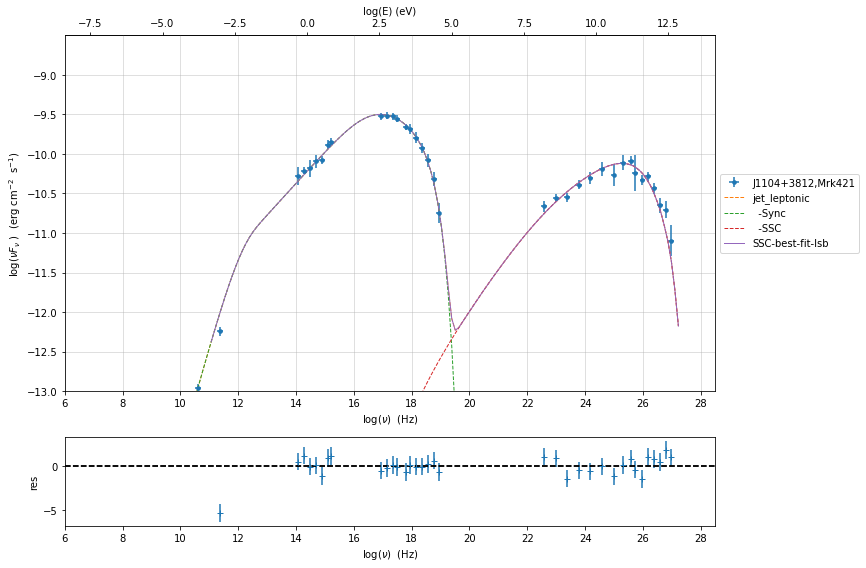

In [30]:
%matplotlib inline
fit_model_lsb.set_nu_grid(1E6,1E30,200)
fit_model_lsb.eval()
p2=fit_model_lsb.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

## Model fitting with Minuit

To run the ``minuit`` minimizer we will use the best-fit results from ``lsb`` to set the boundaries for our parameters. 

In [36]:
from jetset.minimizer import fit_SED,ModelMinimizer
from jetset.model_manager import  FitModel
from jetset.jet_model import Jet

jet_minuit=Jet.load_model('prefit_jet.pkl')
jet_minuit.set_gamma_grid_size(200)
#fit_model_minuit=fit_model_lsb
fit_model_minuit=FitModel( jet=jet_minuit, name='SSC-best-fit-minuit',template=None) 

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.060843e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.188500e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.181578e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.726502e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.112712e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [37]:
fit_model_minuit.show_model_components()



--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: SSC-best-fit-minuit  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------


In [38]:

fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[5E15,1E17]
fit_model_minuit.jet_leptonic.parameters.gmin.fit_range=[10,1000]
fit_model_minuit.jet_leptonic.parameters.gmax.fit_range=[5E5,1E7]
fit_model_minuit.jet_leptonic.parameters.gamma0_log_parab.fit_range=[1E3,1E5]

fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5,50]

In [39]:
model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,sed_data,10**11.,10**29.0,fitname='SSC-best-fit-minuit',repeat=2)

filtering data in fit range = [1.000000e+11,1.000000e+29]
data length 35

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]


- best chisq=4.49773e+01
fit run: 1
- old chisq=4.49773e+01


0it [00:00, ?it/s]


- best chisq=3.73621e+01
-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.696233e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,9.753500e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,8.562561e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.243055e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.097027e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.289243e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.042521e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.156315e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.244392e+01,1.000000e-04,--,False,False



converged=True
calls=815
mesg=


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 37.36                      │       Ncalls = 815 (815 total)       │
│ EDM = 0.000262 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │469.623333 │ 0.000028  │            │            │   10    │  1000   │       │
│ 1 │ par_1 │  975.4e3  │   1.5e3   │            │            │ 500000  │  1e+07  │       │
│ 2 │ par_2 │856.2561e-3│ 0.0005e-3 │            │            │    0    │         │       │
│ 3 │ par_3 │32.430549e3│0.000028e3 │            │            │  1000   │ 100000  │       │
│ 4 │ par_4 │ 2.0970268 │ 0.0000023 │            │            │   -10   │   10    │       │
│ 5 │ par_5 │728.92426e-3│0.00019e-3 │            │            │   -15   │   15    │       │
│ 6 │ par_6 │30.425209e15│0.000005e15│            │            │  5e+15  │  1e+17  │       │
│ 7 │ par_7 │51.563145e-3│0.000026e-3│            │            │    0    │         │       │
│ 8 │ par_8 │ 22.443924 │ 0.000014  │            │            │    5    │   50    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=26
chisq=37.362081, chisq/red=1.437003 null hypothesis sig=0.069318

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,4.696233e+02,4.696233e+02,2.841476e-05,--,4.697542e+02,1.000000e+01,1.000000e+03,False
jet_leptonic,gmax,9.753500e+05,9.753500e+05,1.529901e+03,--,1.373160e+06,5.000000e+05,1.000000e+07,False
jet_leptonic,N,8.562561e-01,8.562561e-01,5.348425e-07,--,9.060843e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,3.243055e+04,3.243055e+04,2.853851e-02,--,3.188500e+04,1.000000e+03,1.000000e+05,False
jet_leptonic,s,2.097027e+00,2.097027e+00,2.250930e-06,--,2.181578e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,7.289243e-01,7.289243e-01,1.911945e-07,--,7.726502e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.042521e+16,3.042521e+16,5.251825e+09,--,3.112712e+16,5.000000e+15,1.000000e+17,False
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,5.156315e-02,5.156315e-02,2.625211e-08,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,beam_obj,2.244392e+01,2.244392e+01,1.401529e-05,--,2.500000e+01,5.000000e+00,5.000000e+01,False


-------------------------------------------------------------------------




you can save results collected so far

In [20]:
best_fit_minuit.save_report('SSC-best-fit-minuit.txt')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

for further information regardin minuit please refer to https://iminuit.readthedocs.io/en/v1.5.4/

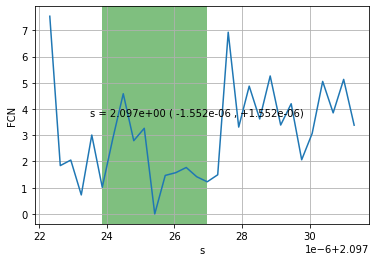

In [49]:
#migrad profile

#access the data
profile_migrad=model_minimizer_minuit.minimizer.mnprofile('s')

#make the plot(no need to run the previous command)
profile_plot_migrad=model_minimizer_minuit.minimizer.draw_mnprofile('s')

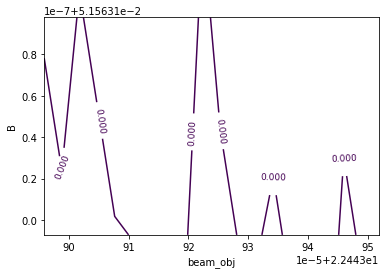

In [41]:
#migrad contour
#access the data
contour_migrad=model_minimizer_minuit.minimizer.contour('beam_obj','B')

#make the plot(no need to run the previous command)
contour_plot_migrad=model_minimizer_minuit.minimizer.draw_contour('beam_obj','B')

you can use also minos contour and profile, in this case the computational time is longer:

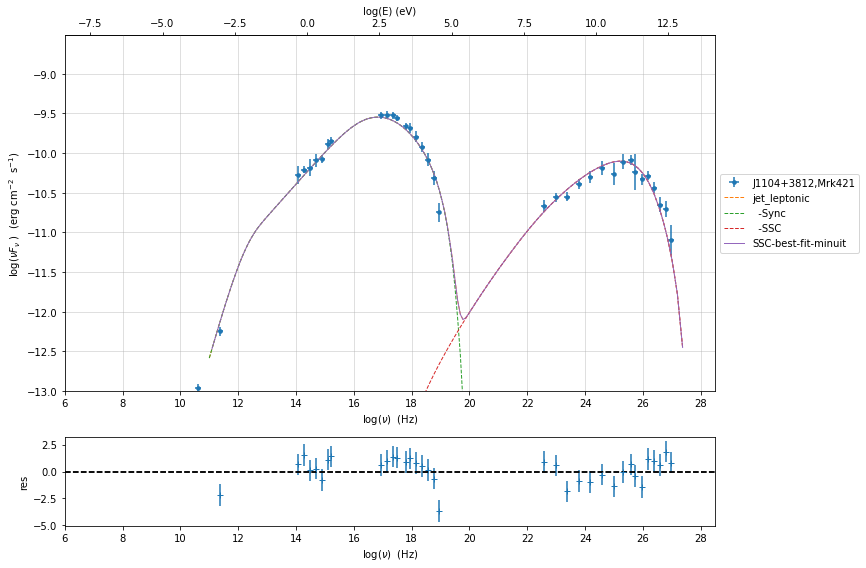

In [29]:
%matplotlib inline
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

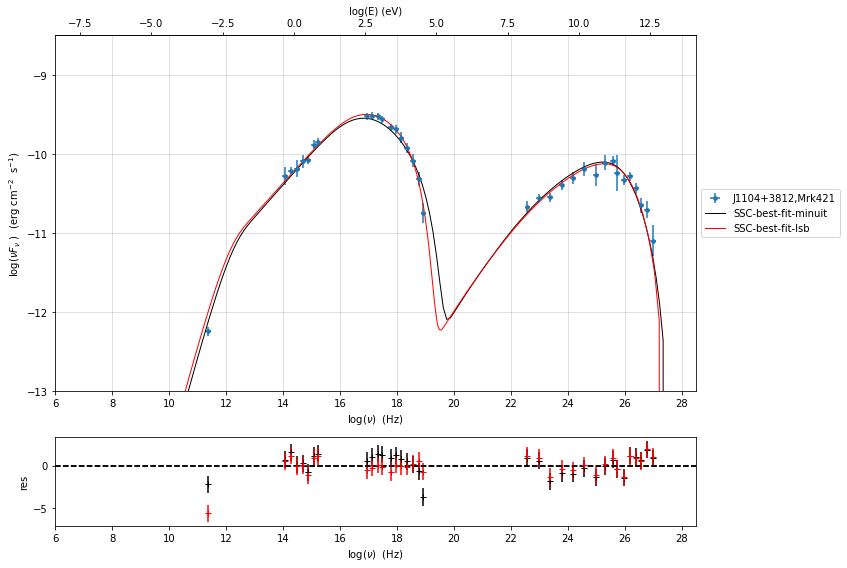

In [30]:
%matplotlib inline
from jetset.plot_sedfit import PlotSED
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_lsb.set_nu_grid(1E6,1E30,500)
fit_model_lsb.eval()
fit_model_minuit.eval()
p2=PlotSED()
p2.add_data_plot(sed_data,fit_range=[ 11.,29.])
p2.add_model_plot(fit_model_minuit,color='black')
p2.add_residual_plot(fit_model_minuit,sed_data,fit_range=[ 11.,29.],color='black')
p2.add_model_plot(fit_model_lsb,color='red')
p2.add_residual_plot(fit_model_lsb,sed_data,fit_range=[ 11.,29.],color='red')
p2.rescale(y_min=-13,x_min=6,x_max=28.5)

## MCMC sampling

In [19]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


We  used a flat prior  centered on the best fit value.   Setting `bound=5.0` and `bound_rel=True` means that:
    
1) the prior interval will be defined as  [best_fit_val - delta_m , best_fit_val + delta_p] 

2) with delta_p=delta_m=best_fit_val*bound

If we set `bound_rel=False` then   delta_p = delta_m = best_fit_err*bound

It is possible to define asymmetric boundaries e.g. `bound=[2.0,5.0]` meaning that 

1) for `bound_rel=True` 

     delta_p = best_fit_val*bound[1]

     delta_m =b est_fit_val*bound[0]

2)  for `bound_rel=False` 

    delta_p = best_fit_err*bound[1]

    delta_m = best_fit_err*bound[0]

In the next release a more flexible prior interface will be added, including different type of priors

Given the large parameter space, we select a sub sample of parameters using the `use_labels_dict`. If we do not pass the 'use_labels_dict' the full set of free parameters will be used


In [20]:
from tqdm.auto import tqdm

model_minimizer_minuit = ModelMinimizer.load_model('model_minimizer_minuit.pkl')

mcmc=McmcSampler(model_minimizer_minuit)

labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.run_sampler(nwalkers=128,burnin=10,steps=50,bound=5.0,bound_rel=True,threads=None,walker_start_bound=0.005,use_labels_dict=use_labels_dict,progress='notebook')

mcmc run starting



  0%|          | 0/50 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 438.89 seconds


In [21]:
print(mcmc.acceptance_fraction)

0.5603125


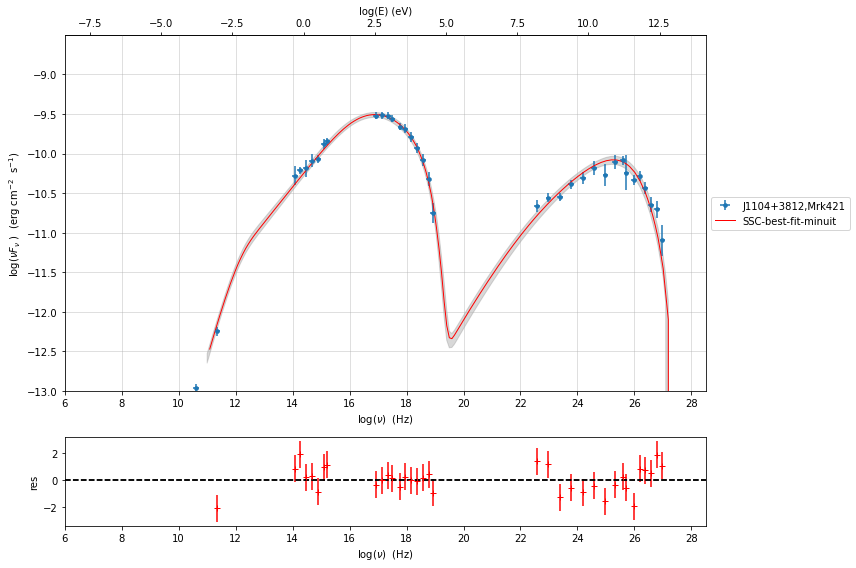

In [22]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[11.,27.4],size=50)
p.rescale(y_min=-13,x_min=6,x_max=28.5)

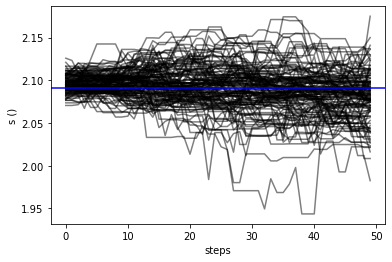

In [23]:
f=mcmc.plot_chain('s',log_plot=False)

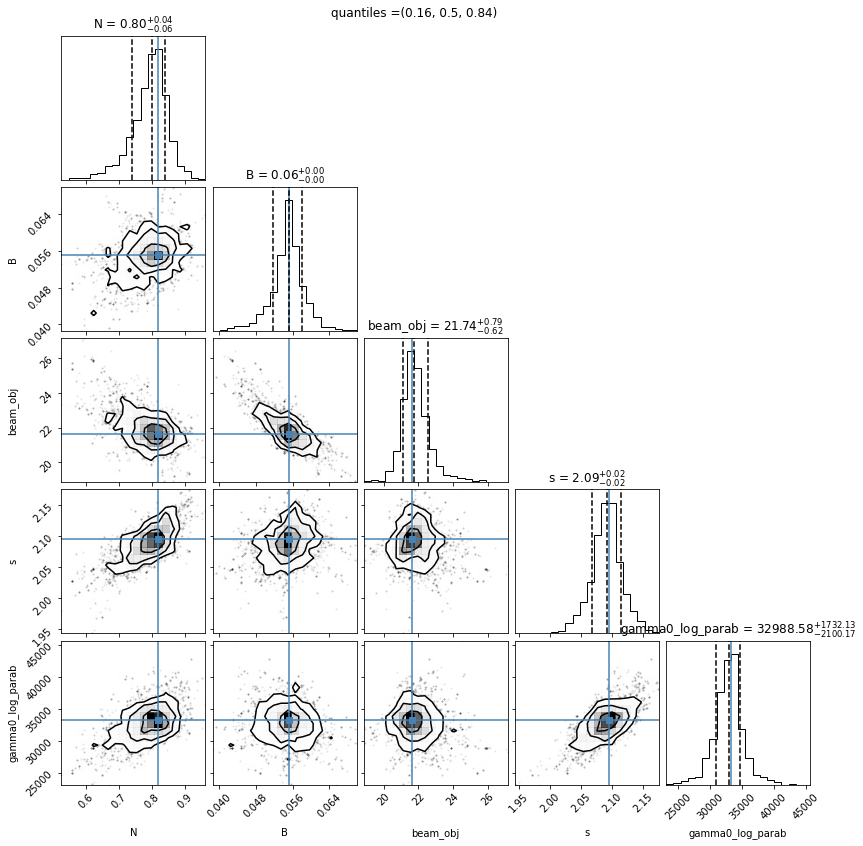

In [24]:
f=mcmc.corner_plot()

In [37]:
mcmc.get_par('N')

(array([2.03985989, 1.97347471, 1.88059101, ..., 2.17080728, 2.16236303,
        1.91671546]),
 0)

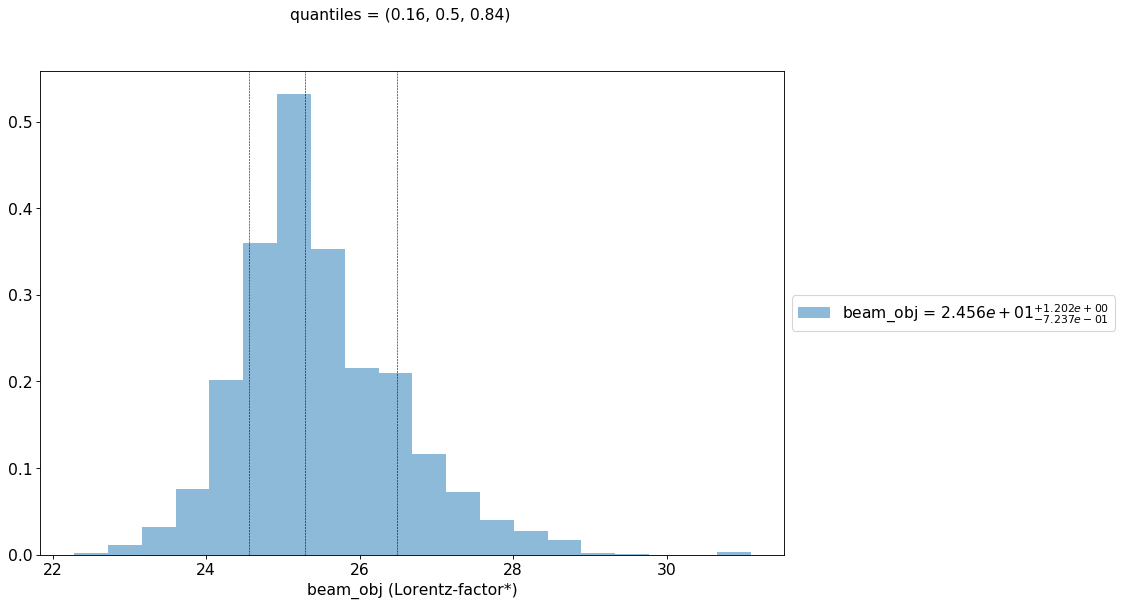

In [38]:
f=mcmc.plot_par('beam_obj')

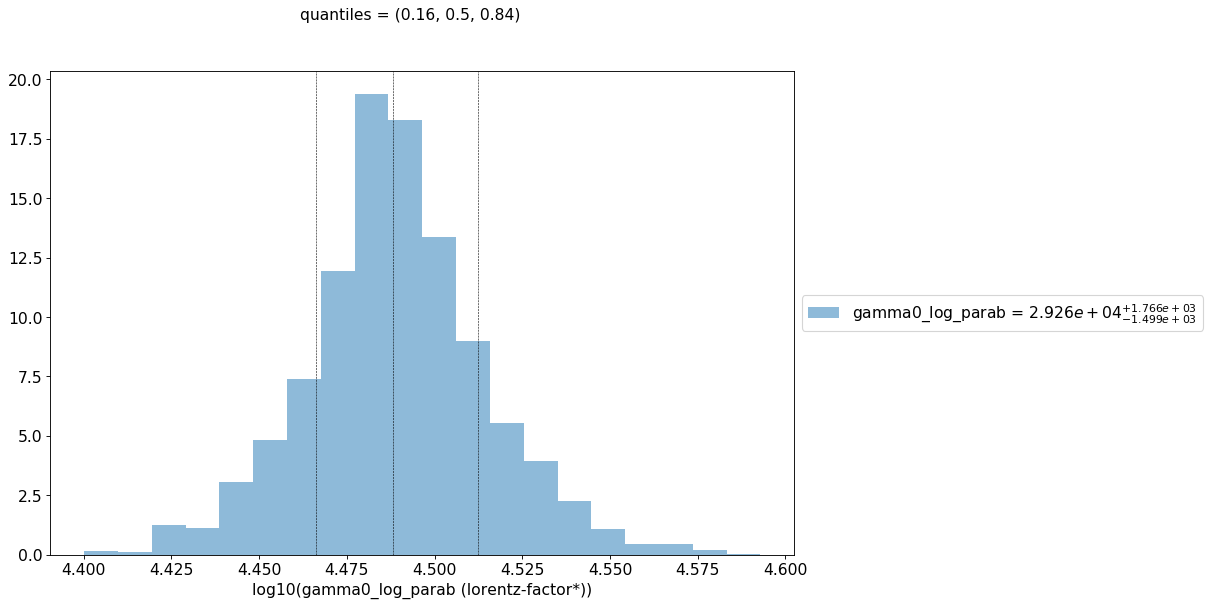

In [39]:
f=mcmc.plot_par('gamma0_log_parab',log_plot=True)

## Save and reuse MCMC

In [40]:
mcmc.save('mcmc_sampler.pkl')

In [41]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_401.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

In [42]:
ms.model.name

'SSC-best-fit-minuit'

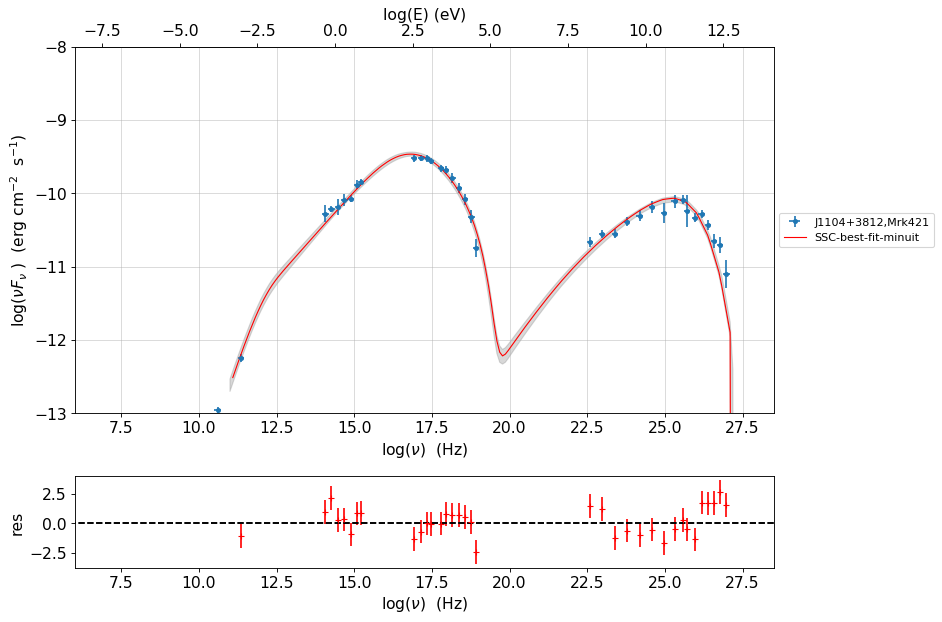

In [43]:
p=ms.plot_model(sed_data=sed_data,fit_range=[11., 27.4],size=50)
p.rescale(y_min=-13,x_min=6,x_max=28.5)

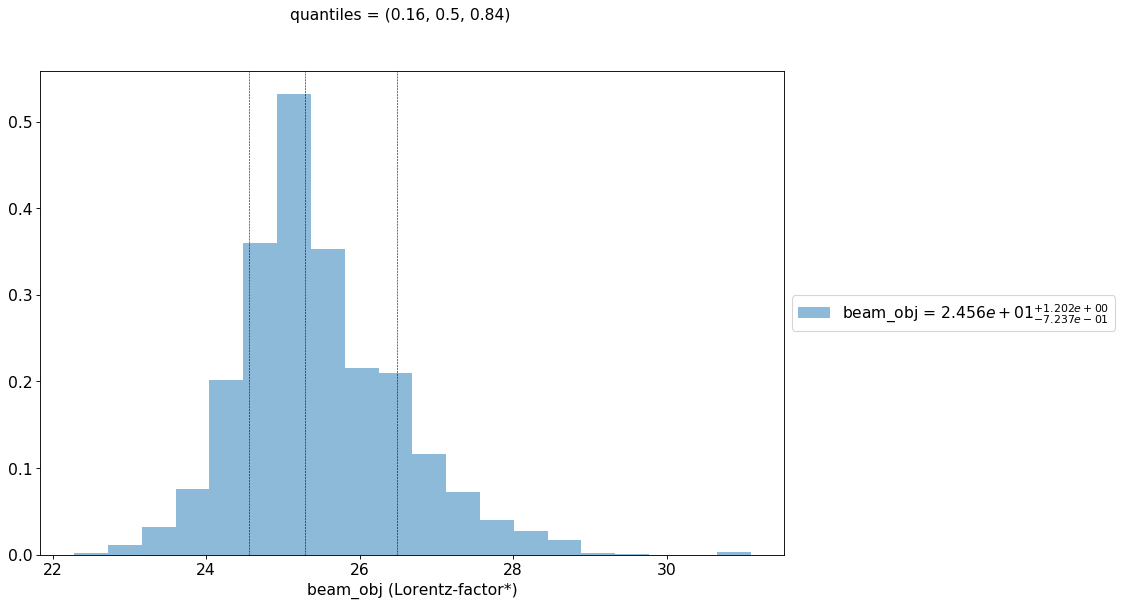

In [44]:
f=ms.plot_par('beam_obj',log_plot=False)


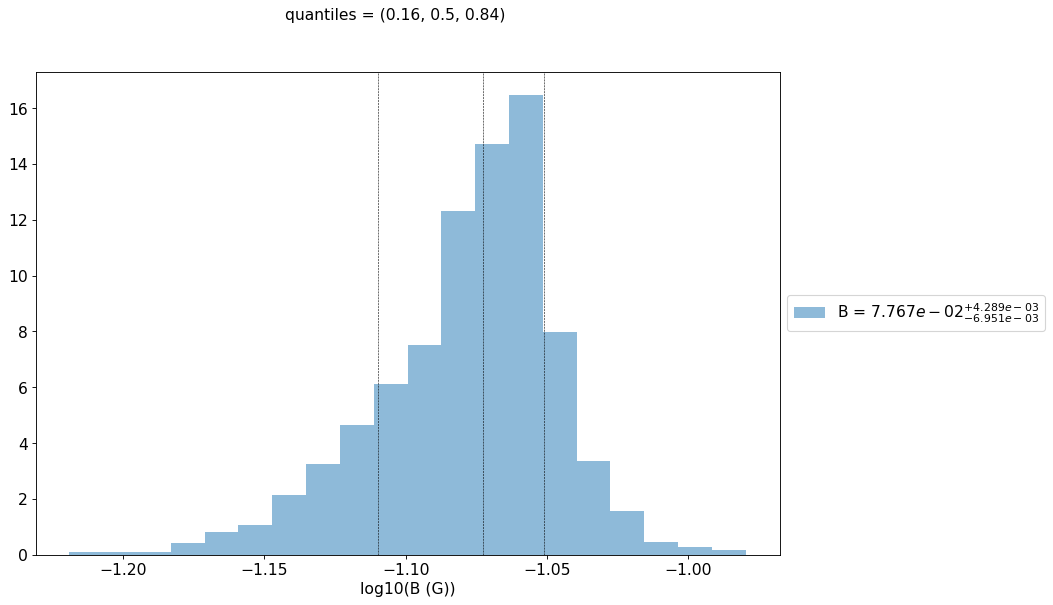

In [45]:
f=ms.plot_par('B',log_plot=True)


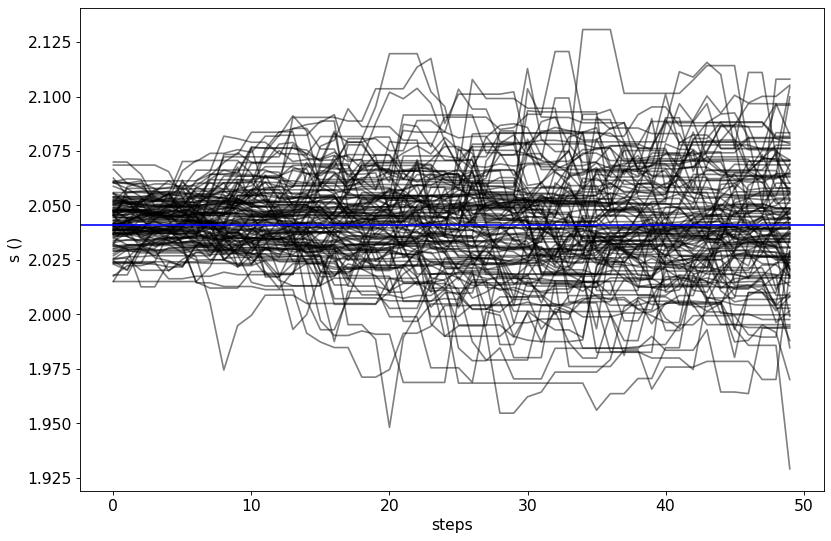

In [46]:
f=ms.plot_chain('s',log_plot=False)

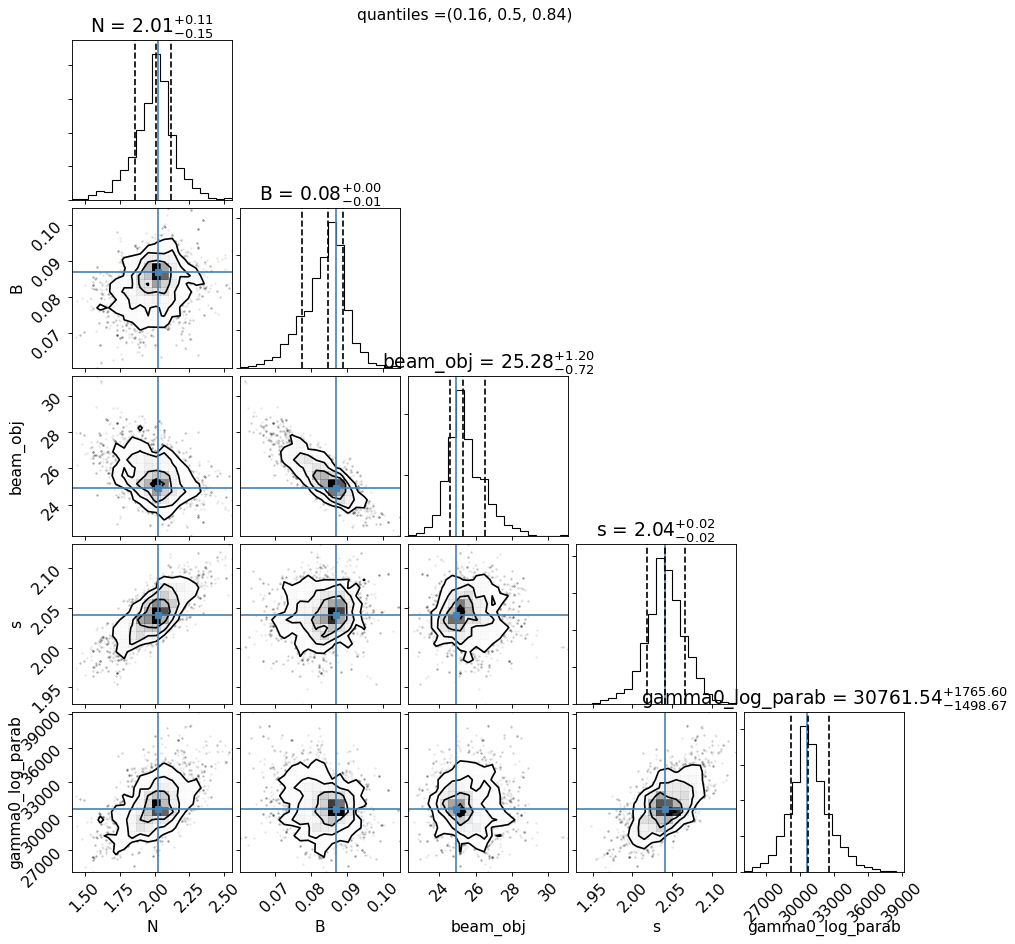

In [47]:
f=ms.corner_plot()